# 0. Abstract

Objetivo del Proyecto
El objetivo principal de este proyecto es desarrollar un sistema de recomendación que sugiera películas basándose en características intrínsecas (géneros, popularidad, calificaciones, ingresos, etc.) mediante la creación de clústeres representativos de grupos de películas similares. Esto permitirá ofrecer recomendaciones personalizadas sin necesidad de datos explícitos de los usuarios, como calificaciones o historial de visualización.

Para lograr este objetivo, se implementarán técnicas de aprendizaje no supervisado para definir los clústeres iniciales y se entrenarán modelos predictivos supervisados para asignar películas a estos clústeres. Además, se evaluará la efectividad del sistema mediante métricas apropiadas y se explorarán mejoras en el rendimiento.

## Hipótesis
- Las características intrínsecas de las películas (género, popularidad, duración, ingresos, y calificaciones promedio) contienen patrones suficientemente diferenciables para formar clústeres coherentes, y estos clústeres permiten generar recomendaciones relevantes y personalizadas para los usuarios sin necesidad de datos explícitos sobre sus preferencias previas.

## Objetivos

1. Definir clústeres representativos:
- Utilizar algoritmos de agrupamiento para clasificar películas basándose en características como género, duración y popularidad.
2. Entrenar un modelo predictivo:
- Predecir a qué clúster pertenece cada película utilizando modelos supervisados.
3. Implementar un sistema de recomendaciones:
- Sugerir películas dentro del mismo clúster para maximizar la relevancia de las recomendaciones.
4. Evaluar el desempeño del sistema:
- Medir la efectividad del agrupamiento y predicción utilizando métricas como accuracy y coeficiente de Silhouette.
5. Optimizar el modelo:
- Ajustar hiperparámetros mediante GridSearchCV para mejorar las predicciones.
6. Analizar la influencia de las características:
- Determinar qué variables impactan más en los clústeres y predicciones mediante gráficos de importancia.


# 1. Importar librerías

In [120]:
import pandas as pd
import numpy as np
import zipfile
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import VarianceThreshold
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from scipy.stats import randint
from sklearn.metrics import roc_auc_score, classification_report, accuracy_score, roc_curve

# 2. Cargamos el dataset

En particular, utilizaremos github para acceder al csv, este se cargo en formato zip por limitancias de tamaño de github. para suplir esto utilizamos la librería zipfile.

In [73]:
# Descargamos el dataset
!wget -O movies_metadata.zip https://github.com/PGrimaldiP/proyecto_ds_recomendador/raw/main/movies_metadata.csv.zip

with zipfile.ZipFile('movies_metadata.zip', 'r') as zip_ref:
    zip_ref.extractall('movies_metadata')

# Referenciamos el path del csv utilizando movies_metadata
csv_file_path = 'movies_metadata/movies_metadata.csv'
df = pd.read_csv(csv_file_path)

--2024-12-06 01:30:56--  https://github.com/PGrimaldiP/proyecto_ds_recomendador/raw/main/movies_metadata.csv.zip
Resolving github.com (github.com)... 20.27.177.113
Connecting to github.com (github.com)|20.27.177.113|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/PGrimaldiP/proyecto_ds_recomendador/main/movies_metadata.csv.zip [following]
--2024-12-06 01:30:57--  https://raw.githubusercontent.com/PGrimaldiP/proyecto_ds_recomendador/main/movies_metadata.csv.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.111.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 12796073 (12M) [application/zip]
Saving to: ‘movies_metadata.zip’

movies_metadata.zip 100%[===================>]  12.20M  23.8MB/s    in 0.5s    

2024-12-06 01:30:58 (23.8 MB/s) - ‘movies_

<ipython-input-73-134ff41f3f96>:9: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(csv_file_path)


# 3. Análisis preeliminar

Comenzaremos con un análisis preeliminar del dataset, esto paso forma parte del EDA, pero se prefiere tener por separado para tener un contexto general del dataset previo a la exploración más profunda de los datos.

Comenzaremos viendo el head del proyecyo para tener un contexto general de las variables de este mismo.

In [74]:
# Display the first few rows of the dataframe
df.head()

,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,...,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count
0,False,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",http://toystory.disney.com/toy-story,862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",...,1995-10-30,373554033.0,81.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,NaN,Toy Story,False,7.7,5415.0
1,False,NaN,65000000,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",NaN,8844,tt0113497,en,Jumanji,When siblings Judy and Peter discover an encha...,...,1995-12-15,262797249.0,104.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Roll the dice and unleash the excitement!,Jumanji,False,6.9,2413.0
2,False,"{'id': 119050, 'name': 'Grumpy Old Men Collect...",0,"[{'id': 10749, 'name': 'Romance'}, {'id': 35, ...",NaN,15602,tt0113228,en,Grumpier Old Men,A family wedding reignites the ancient feud be...,...,1995-12-22,0.0,101.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Still Yelling. Still Fighting. Still Ready for...,Grumpier Old Men,False,6.5,92.0
3,False,NaN,16000000,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",NaN,31357,tt0114885,en,Waiting to Exhale,"Cheated on, mistreated and stepped on, the wom...",...,1995-12-22,81452156.0,127.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Friends are the people who let you be yourself...,Waiting to Exhale,False,6.1,34.0
4,False,"{'id': 96871, 'name': 'Father of the Bride Col...",0,"[{'id': 35, 'name': 'Comedy'}]",NaN,11862,tt0113041,en,Father of the Bride Part II,Just when George Banks has recovered from his ...,...,1995-02-10,76578911.0,106.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Just When His World Is Back To Normal... He's ...,Father of the Bride Part II,False,5.7,173.0


In [75]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45466 entries, 0 to 45465
Data columns (total 24 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   adult                  45466 non-null  object 
 1   belongs_to_collection  4494 non-null   object 
 2   budget                 45466 non-null  object 
 3   genres                 45466 non-null  object 
 4   homepage               7782 non-null   object 
 5   id                     45466 non-null  object 
 6   imdb_id                45449 non-null  object 
 7   original_language      45455 non-null  object 
 8   original_title         45466 non-null  object 
 9   overview               44512 non-null  object 
 10  popularity             45461 non-null  object 
 11  poster_path            45080 non-null  object 
 12  production_companies   45463 non-null  object 
 13  production_countries   45463 non-null  object 
 14  release_date           45379 non-null  object 
 15  re

Lo primero que observamos es que el conjunto de datos se encuentra compuesto por 45.465 registros y de 24 columnas, por lo tanto es un dataset con más de 1 millón de datos. Adicionalmente en esta primera lectura observamos que la mayoría de las columnas son de tipo object con sólo 4 columnas tipo float. Dentro de las columnas tenemos algunos registros con información completa y otros con información faltante.

En base a los objetivos del proyecto definiremos como variables clave las siguientes

- popularity, que indicará la popularidad de las películas
- revenue, serán los ingresos recaudados por las películas
- runtime, la duración de las películas
- vote_average, la nota promedio o votación promedio
- vote_count, la cantidad de votos recibidos

Realizaremos un análisis de las variables categóricas

In [76]:
# Generamos un análisis estadístico básico para las variables categóricas
print(df.describe(include='object'))

        adult                              belongs_to_collection budget  \
count   45466                                               4494  45466   
unique      5                                               1698   1226   
top     False  {'id': 415931, 'name': 'The Bowery Boys', 'pos...      0   
freq    45454                                                 29  36573   

                               genres                     homepage      id  \
count                           45466                         7782   45466   
unique                           4069                         7673   45436   
top     [{'id': 18, 'name': 'Drama'}]  http://www.georgecarlin.com  141971   
freq                             5000                           12       3   

          imdb_id original_language original_title            overview  \
count       45449             45455          45466               44512   
unique      45417                92          43373               44307   
top     tt1

Para las variables categóricas de los objetivos señalado vemos que en popularity llama la atención la alta variabilidad al tener una amplia cantidad de valores únicos [sobre el 95% del total] teniendo el top con valor 0 y con una frecuancia de 34 casos, muy bajo para la cantidad de datos.

Ahora realizaremos un análisis de las variables numéricas del proyecto

In [77]:
# Display the first few rows of the dataframe
df.describe()

,revenue,runtime,vote_average,vote_count
count,4.546000e+04,45203.000000,45460.000000,45460.000000
mean,1.120935e+07,94.128199,5.618207,109.897338
std,6.433225e+07,38.407810,1.924216,491.310374
min,0.000000e+00,0.000000,0.000000,0.000000
25%,0.000000e+00,85.000000,5.000000,3.000000
50%,0.000000e+00,95.000000,6.000000,10.000000
75%,0.000000e+00,107.000000,6.800000,34.000000
max,2.787965e+09,1256.000000,10.000000,14075.000000


Como mencionamos anteriormente las variables float son las más interesantes para el análisis de recomendador que queremos realizar.

Vemos en revenue, runtime y vote_count una alta dispersión en base a la std, mientras que para vote_average es un poco más baja.

Las cuatro variables tienen como valor mínimo el 0.

Para el caso de revenue vemos que gran parte de la muestra pareciera centrarse en torno al 0, pues bajo el 75& sigue siendo 0.0

Desde esta muestra se podría intuir que es posible se deba realizar un análisis de outliers para estas variables.

# 4. EDA

A continuación continuaremos explorando en mayor profundidad las variables y hallazgos mencionados previamente.

Comenzaremos con uno de los primeros levantamientos, los valores nulos.

In [78]:
# Verificaremos la cantidad de valores nulos en el dataset
missing_values = df.isnull().sum()

# Calculamos la cantidad de columnas que tienen valores nulos
num_columns_with_nulls = missing_values[missing_values > 0].count()
# Calculamos la cantidad total de columnas en el DataFrame
total_columns = df.shape[1]
# Calculamos el porcentaje de columnas con valores nulls
perc_missing_values = num_columns_with_nulls / total_columns * 100

# Imprimir los resultados
print(f"Cantidad de variables con valores nulos: {num_columns_with_nulls}")
print(f"Cantidad total de variables: {perc_missing_values}")
print(f"")
print("Cantidad de valores nulos por variable")
# Ordenamos los valores missing para comprender las variables más afectadas
missing_values_sorted = missing_values[missing_values > 0].sort_values(ascending=False)
print(missing_values_sorted)


Cantidad de variables con valores nulos: 19
Cantidad total de variables: 79.16666666666666

Cantidad de valores nulos por variable
belongs_to_collection    40972
homepage                 37684
tagline                  25054
overview                   954
poster_path                386
runtime                    263
status                      87
release_date                87
imdb_id                     17
original_language           11
revenue                      6
spoken_languages             6
title                        6
video                        6
vote_average                 6
vote_count                   6
popularity                   5
production_countries         3
production_companies         3
dtype: int64


<ipython-input-79-a05990cea0b0>:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=missing_values_percent, y=missing_values_percent.index, palette="viridis")


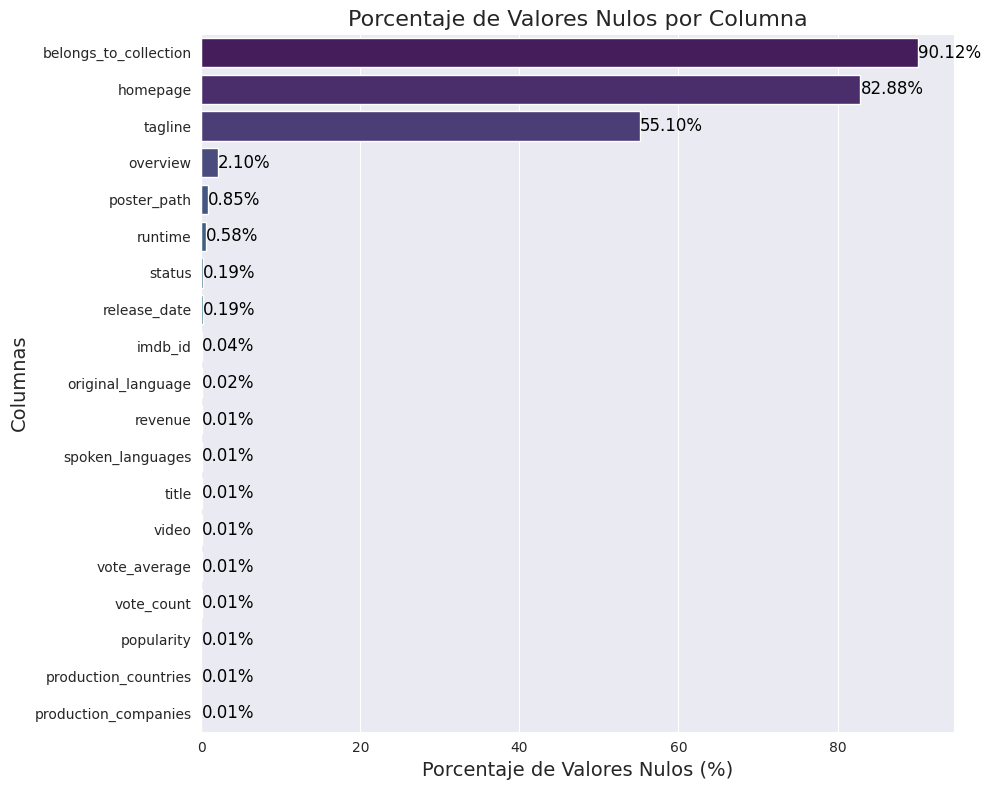

In [79]:
# Verificamos la cantidad de valores nulos en el dataset
missing_values = df.isnull().sum()

# Calculamos el porcentaje de valores nulos por columna
missing_values_percent = (missing_values / len(df)) * 100

# Filtramos solo las columnas que tienen valores nulos
missing_values_percent = missing_values_percent[missing_values_percent > 0].sort_values(ascending=False)

# Crear un gráfico de barras para mostrar el porcentaje de valores nulos por columna
plt.figure(figsize=(10, 8))
sns.barplot(x=missing_values_percent, y=missing_values_percent.index, palette="viridis")

# Añadir títulos y etiquetas
plt.title("Porcentaje de Valores Nulos por Columna", fontsize=16)
plt.xlabel("Porcentaje de Valores Nulos (%)", fontsize=14)
plt.ylabel("Columnas", fontsize=14)

# Añadir etiquetas con los porcentajes dentro de las barras
for i, value in enumerate(missing_values_percent):
    plt.text(value, i, f"{value:.2f}%", ha='left', va='center', color='black', fontsize=12)

# Mostrar el gráfico
plt.tight_layout()
plt.show()

Vemos que en primer lugar existen 3 variables con una alta cantidad de nulls, afortunamdamente ninguna de estas son las variables que preeliminarmente escogimos como relevantes para el proyecto [se debe realizar un método de selección de variables aún]. Vemos que de las variables mencionados anteriormente tenemos % de null bastante menores, siendo sólo mayor el de runtime, pero representando menos del 1% de la cantidad de registros.

Debido a esto es un paso que debemos verificar una vez terminado el EDA, preeliminarmente se piensa que lo mejor sería descartar las columnas con alto nivel de nulls y eliminar los registros en aquellas columnas con bajo nivel de nulls, es importante recordar que el dataset tiene 45 mil filas.

Ahora comenzaremos a revisar la distribución de las variables numéricas del dataset.

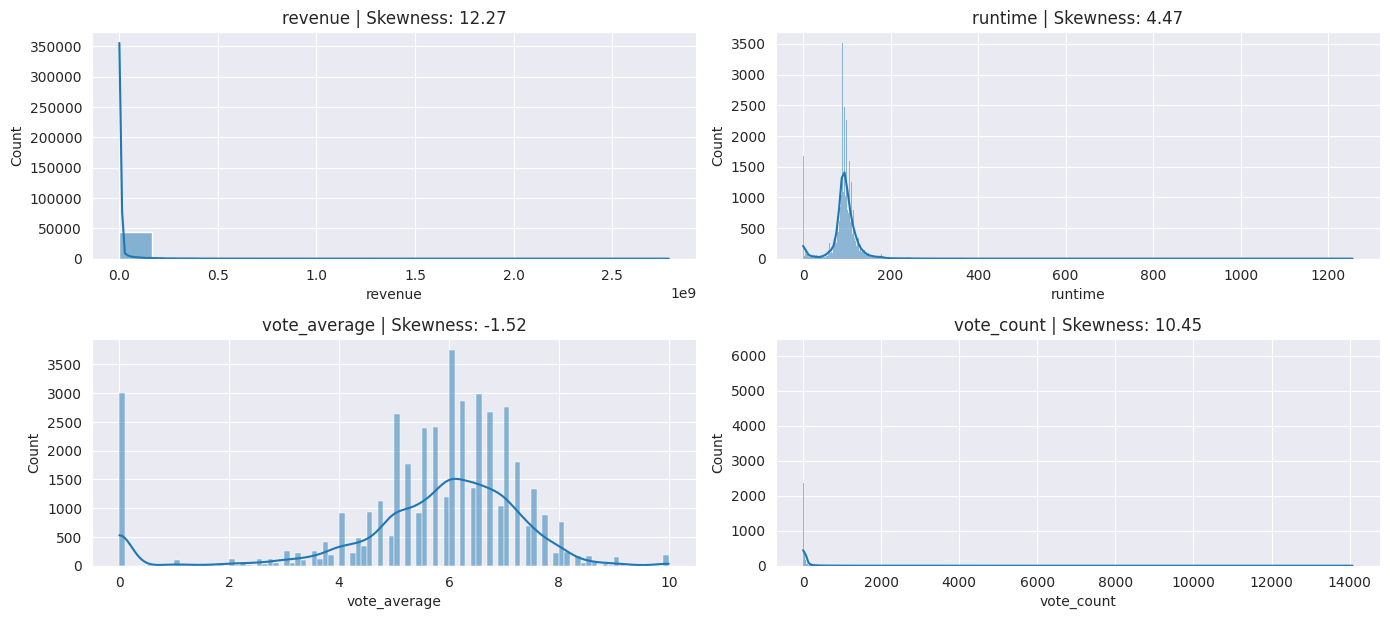

In [80]:
# Configuramos el estilo Seaborn
sns.set_style("darkgrid")

# Identificar columnas numéricas, de las cuáles todas son variables clave
numerical_columns = df.select_dtypes(include=["int64", "float64"]).columns

# Graficamos la distribución para cada columna numércia
plt.figure(figsize=(14, len(numerical_columns) * 3))
for idx, feature in enumerate(numerical_columns, 1):
    plt.subplot(len(numerical_columns), 2, idx)
    sns.histplot(df[feature], kde=True)
    plt.title(f"{feature} | Skewness: {round(df[feature].skew(), 2)}")

plt.tight_layout()
plt.show()

Vemos en primer lugar sesgo relevante, en todas las variables analizadas, en donde sólo los votos promedios parecieran tener una distribución normal, exceptuando los casos de 0 votos. El resto de las variables tienen presencias relevantes de outliers, los cuáles deberán ser analizados posteriormente con alguna estrategia para tratamiento de outliers.

Ahora pasaremos a revisar la distribución de las variables del set utilizando gráficos tipo boxplot y scatterplot, aunque previamente revisaremos las medidas estadísticas básicas para tener una mirada general ahora que hemos transformado nuestras variables.

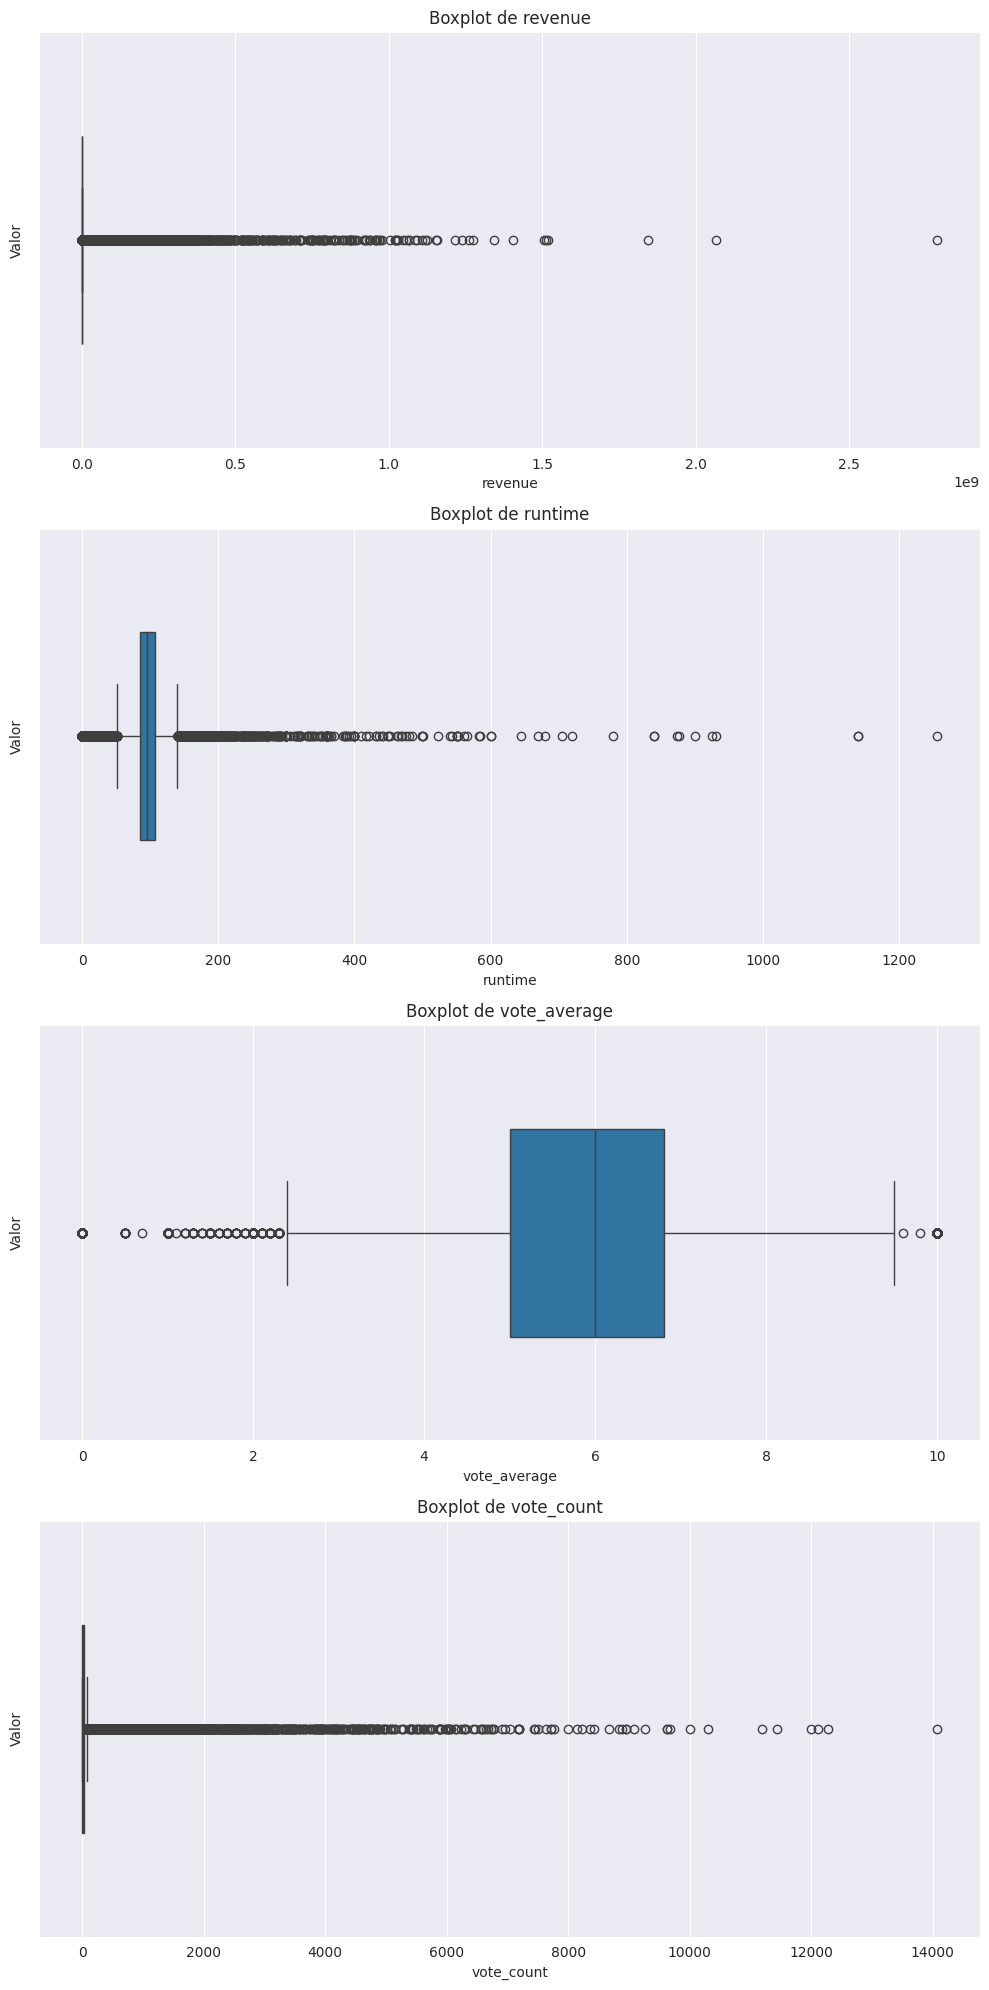

In [81]:
# Graficamos un boxplot para cada columna numérica de forma individual
plt.figure(figsize=(10, len(numerical_columns) * 5))

for idx, feature in enumerate(numerical_columns, 1):
    plt.subplot(len(numerical_columns), 1, idx)
    sns.boxplot(x=df[feature], width=0.5)
    plt.title(f"Boxplot de {feature}")
    plt.xlabel(f"{feature}")
    plt.ylabel("Valor")

plt.tight_layout()
plt.show()

Esta visualización permite apoyar el análisis previo, tenemos datos con un alto nivel de sesgo debido a una amplia cantidad de outliers, siendo en menor medida el caso de la variable voto promedio.

- Revenue: Tenemos una alta concentración en valores inferiores sobre el total observando un sesgo importante hacia la derecha
- Runtime: Tenemos una distribución un poco similar a una normal, en donde los bigotes del boxplot tienen distancias similares hacia la mediana, sin embargo, vemos outliers presentes tanto a la izquierda como a la derecha, podría ser que el dataset incluya películas de larga duración tipo nicho, como películas de corta duración como cortometrajes.
- Vote_average: Este es la única variable que tiene menos sesgo, a pesar de esto posee un poco, vemos una mediana no centrada del todo en la caja y una distancia de los bigotes similar. Adicionalmente, vemos una concentración de outliers en 0 y valores bajos.
- Vote_count: en este caso vemos una cantidad de outliers relevantes, lo que lleva a pensar que gran parte de las películas tiene una baja cantidad de votos, indicando que el voto promedio podría ser poco representativo para estas películas.

Continuaremos analizando las variables categóricas del ejercicio

In [82]:
# Filtrar columnas categóricas del dataset
categorical_columns = df.select_dtypes(include=["object"]).columns

# Analizar las frecuencias de las columnas categóricas
for column in categorical_columns:
    print(f"\nFrecuencia de la variable categórica '{column}':")
    print(df[column].value_counts(dropna=False).head(10))  # Mostramos los 10 valores más comunes



Frecuencia de la variable categórica 'adult':
adult
False                                                                                                                             45454
True                                                                                                                                  9
 - Written by Ørnås                                                                                                                   1
 Rune Balot goes to a casino connected to the October corporation to try to wrap up her case once and for all.                        1
 Avalanche Sharks tells the story of a bikini contest that turns into a horrifying affair when it is hit by a shark avalanche.        1
Name: count, dtype: int64

Frecuencia de la variable categórica 'belongs_to_collection':
belongs_to_collection
NaN                                                                                                                                                         

<ipython-input-83-1f4aa0bb535c>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, y=column, order=df[column].value_counts().index[:top_n], palette="muted")


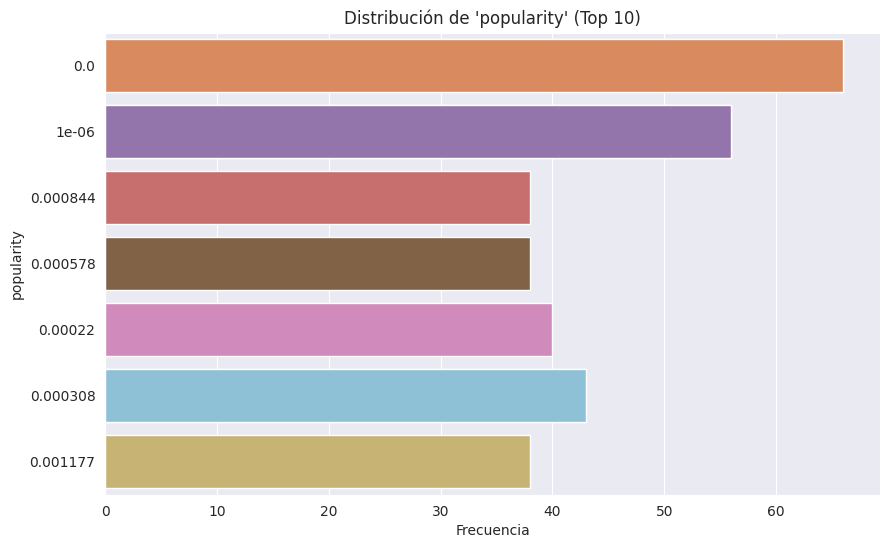

<ipython-input-83-1f4aa0bb535c>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, y=column, order=df[column].value_counts().index[:top_n], palette="muted")


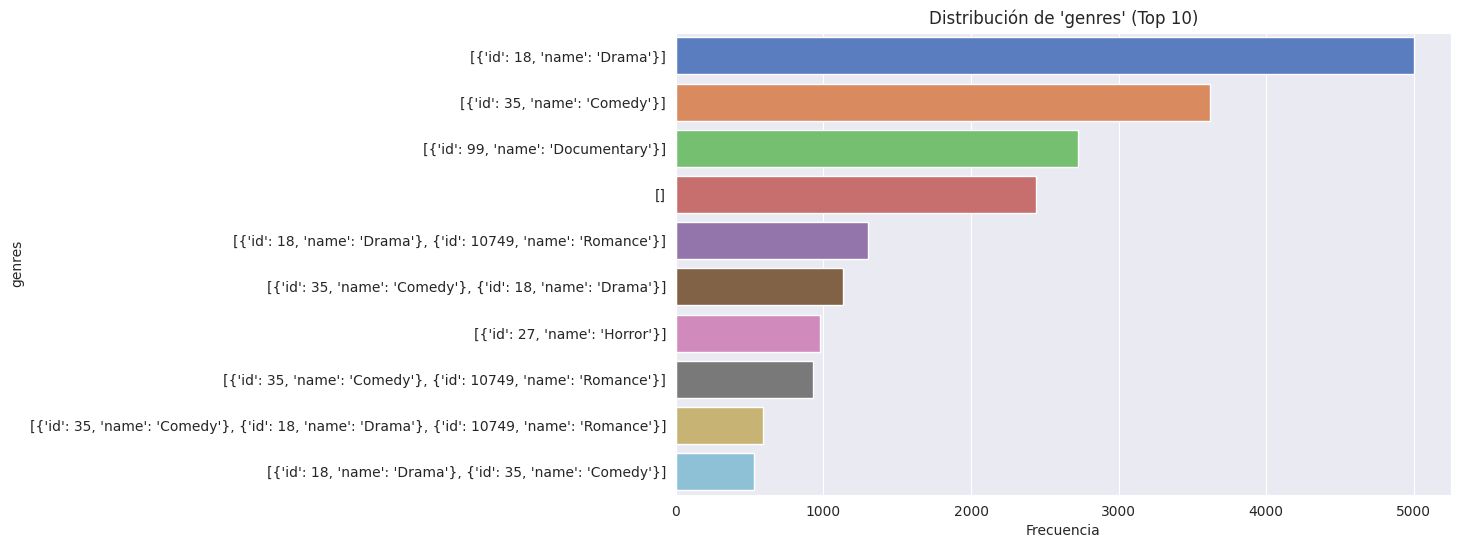

<ipython-input-83-1f4aa0bb535c>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, y=column, order=df[column].value_counts().index[:top_n], palette="muted")


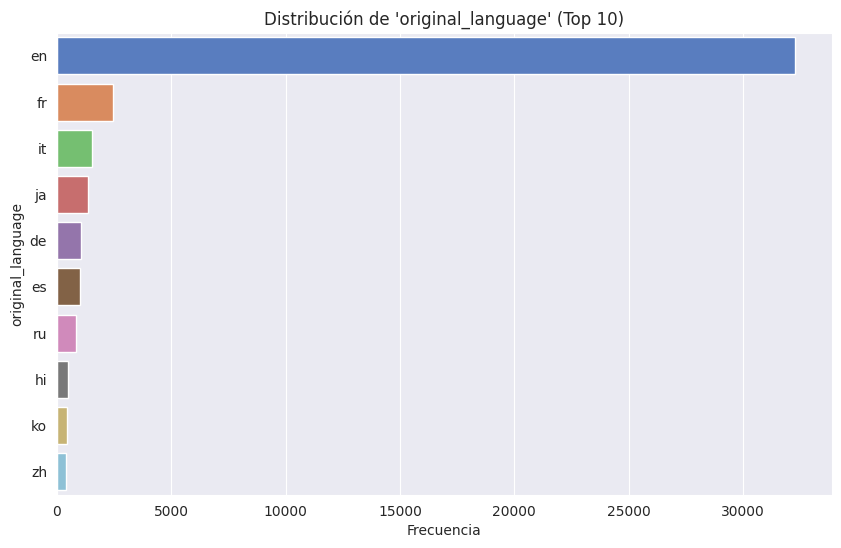

<ipython-input-83-1f4aa0bb535c>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, y=column, order=df[column].value_counts().index[:top_n], palette="muted")


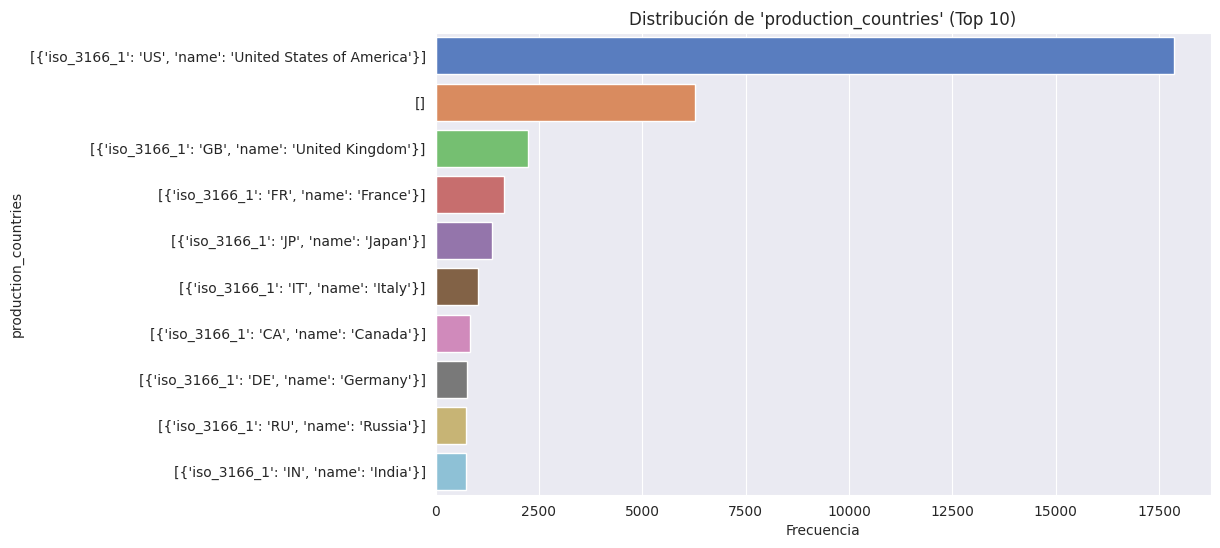

<ipython-input-83-1f4aa0bb535c>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, y=column, order=df[column].value_counts().index[:top_n], palette="muted")


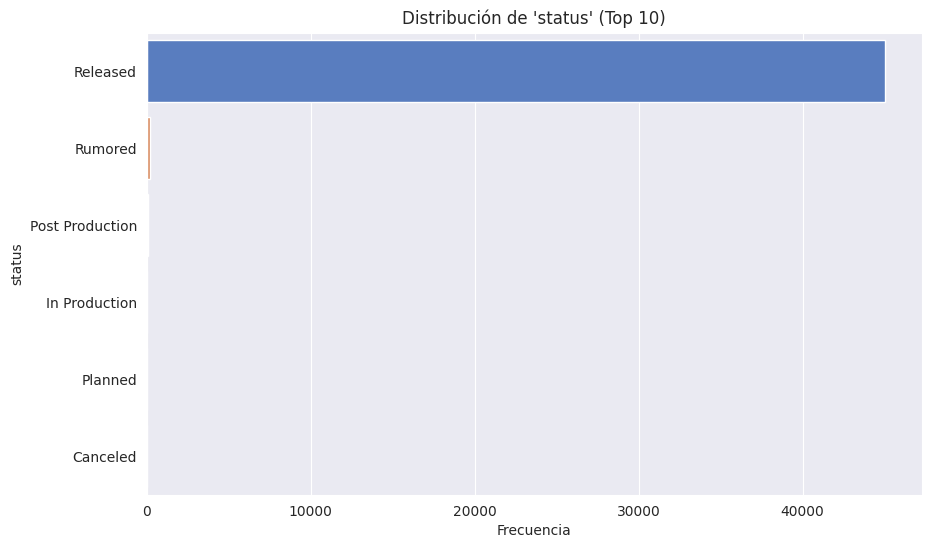

In [83]:
# Gráficos de distribución para algunas variables categóricas
def plot_categorical_distribution(column, top_n=10):
    plt.figure(figsize=(10, 6))
    sns.countplot(data=df, y=column, order=df[column].value_counts().index[:top_n], palette="muted")
    plt.title(f"Distribución de '{column}' (Top {top_n})")
    plt.ylabel(f"{column}")
    plt.xlabel("Frecuencia")
    plt.show()

# Algunas variables categóricas para analizar
categorical_columns_to_plot = ['popularity','genres', 'original_language', 'production_countries', 'status']

# Graficamos la distribución de las variables categóricas
for column in categorical_columns_to_plot:
    plot_categorical_distribution(column)


Lo primero que obtenemos de esto es que la variable popularity no son números cerrados, si no decimales, por lo que debemos transformar esta variable a float y realizar un análisis correspondiente a una variable continua.

In [84]:
df['popularity'] = pd.to_numeric(df['popularity'], errors='coerce')

In [85]:
df['budget'] = pd.to_numeric(df['budget'], errors='coerce')

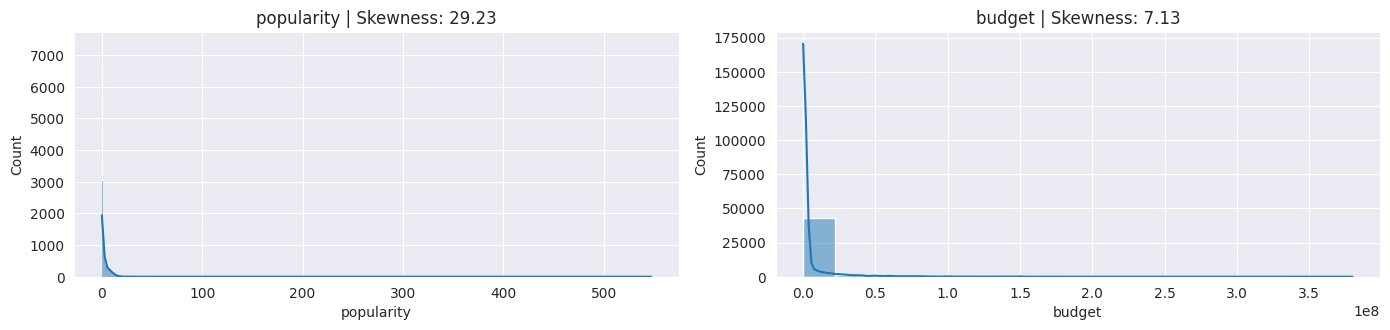

In [86]:
# Identificar columnas numéricas clave
numerical_columns_2 = df[['popularity', 'budget']]

# Graficamos la distribución para cada columna numérica
plt.figure(figsize=(14, len(numerical_columns_2.columns) * 3))
for idx, feature in enumerate(numerical_columns_2.columns, 1):
    plt.subplot(len(numerical_columns_2.columns), 2, idx)
    sns.histplot(df[feature].dropna(), kde=True)  # Eliminar valores nulos antes de graficar
    plt.title(f"{feature} | Skewness: {round(df[feature].skew(), 2)}")

plt.tight_layout()
plt.show()


En este caso observamos 1 distribución similar a la que vimos en revenue, con una alta concentración en valores 0 y un sesgo importante a la derecha. Acompañaremos esto de un boxplot para etender las medidas de tendencia central.

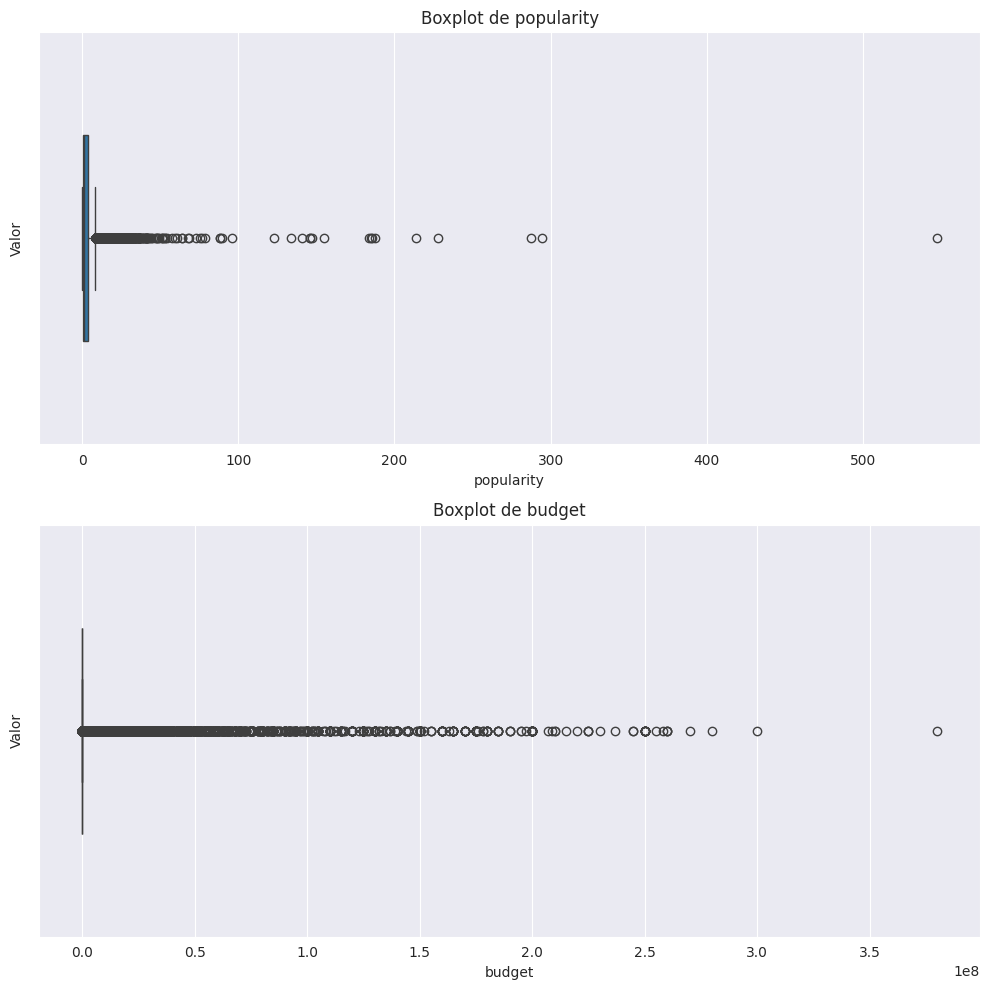

In [87]:
# Graficamos un boxplot para cada columna numérica de forma individual
plt.figure(figsize=(10, len(numerical_columns_2.columns) * 5))

for idx, feature in enumerate(numerical_columns_2.columns, 1):
    plt.subplot(len(numerical_columns_2.columns), 1, idx)
    sns.boxplot(x=df[feature].dropna(), width=0.5)  # Eliminar valores nulos antes de graficar
    plt.title(f"Boxplot de {feature}")
    plt.xlabel(f"{feature}")
    plt.ylabel("Valor")

plt.tight_layout()
plt.show()

Como se mencionó anteriormente, es similar a revenue con una alta concentración en torno a valores bajos, pero con un sesgo a la derecha importante. Por lo que esta variable requerirá de tratamiento de outliers.

Ahora estudiaremos la correlación de las variables numéricas

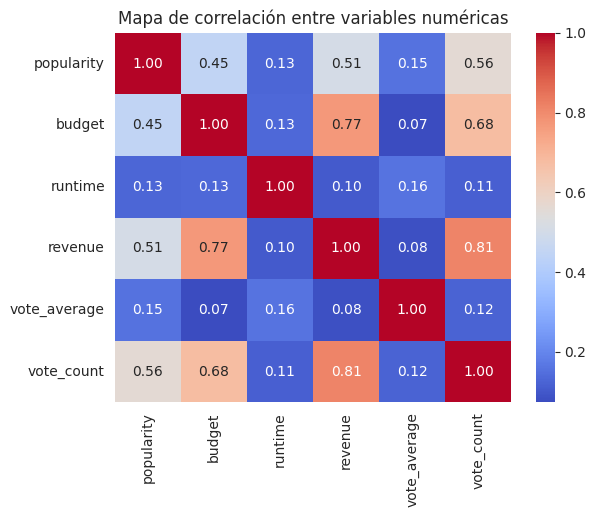

In [88]:
# Correlación entre las variables numéricas
correlation = df[['popularity', 'budget','runtime','revenue', 'vote_average', 'vote_count']].corr()
sns.heatmap(correlation, annot=True, cmap='coolwarm', fmt='.2f')
plt.title("Mapa de correlación entre variables numéricas")
plt.show()

Vemos que la mayoría de las variables numéricas no tiene una correlación llamativa, salvo la relación de revenue y la cantidad de votos, podríamos pensar que las películas que más recaudan reciben más votos, esto puede ser un efecto de que a más recaudación mayor cantidad de visualizaciones y más público implica más personas disponibles a votar, dado que esto es una cantidad y no una escala de votos entre el dataset. De todas formas esto sólo prueba correlación, no causalidad.

Todas las variables tienen una correlación positiva, si revisamos específicamete vote_average y popularity vemos una correlación positiva baja en torno al 0.15, esto para responder la primera pregunta.



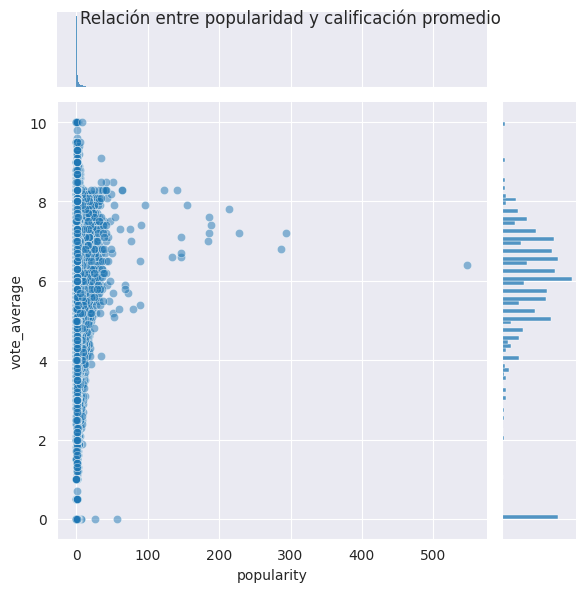

In [89]:
# Gráficos conjuntos para explorar la relación entre popularidad y calificación promedio
sns.jointplot(x='popularity', y='vote_average', data=df, kind='scatter', alpha=0.5)
plt.suptitle("Relación entre popularidad y calificación promedio")
plt.show()

Con esto podemos ir respondiendo la primera pregunta, que es
- Las películas con mejores calificaciones y popularidad tienden a recibir recomendaciones más positivas.

Existe una correlación positiva débil entre las películas con mejores calificaciones (vote_average) y su popularidad (popularity). Dicho esto, aunque las películas con mejores calificaciones tienden a ser un poco más populares, no es un factor determinante en si reciben o no recomendaciones más positivas.

Para responder la segunda pregunta y dada la similitud con una distribución normal de vote_average consideraremos el criterio de película disfrutada como la media + 1 desviación estándar

In [90]:
# Definir un umbral de películas 'disfrutadas'
media_vote_average = df['vote_average'].mean()
desvest_vote_average = df['vote_average'].std()
criterio_disfrutadas = media_vote_average + desvest_vote_average
print(f"Criterio disfrutadas: {criterio_disfrutadas}")

disfrutadas = df[df['vote_average'] > criterio_disfrutadas]


Criterio disfrutadas: 7.54242320665716


In [91]:
# Explodemos la columna de géneros para tener un género por fila
df_exploded = df.explode('genres')

# Comparar cuántas películas 'disfrutadas' comparten géneros con las demás
df_exploded['is_genre_shared'] = df_exploded['genres'].isin(disfrutadas.explode('genres')['genres'])

# Agrupar por géneros compartidos y analizar la media de calificaciones o popularidad
shared_genre_stats = df_exploded.groupby('is_genre_shared')[['vote_average', 'popularity']].mean()

print(shared_genre_stats)


                 vote_average  popularity
is_genre_shared                          
False                5.559383    4.288432
True                 5.632365    2.592471


<ipython-input-92-8b4f8fef842d>:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=shared_genre_stats.index, y=shared_genre_stats['vote_average'], ax=ax[0], palette=palette)
<ipython-input-92-8b4f8fef842d>:17: UserWarning: The palette list has more values (8) than needed (2), which may not be intended.
  sns.barplot(x=shared_genre_stats.index, y=shared_genre_stats['vote_average'], ax=ax[0], palette=palette)
<ipython-input-92-8b4f8fef842d>:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=shared_genre_stats.index, y=shared_genre_stats['popularity'], ax=ax[1], palette=palette)
<ipython-input-92-8b4f8fef842d>:25: UserWarning: The palette list has more values (8) than needed (2), which may 

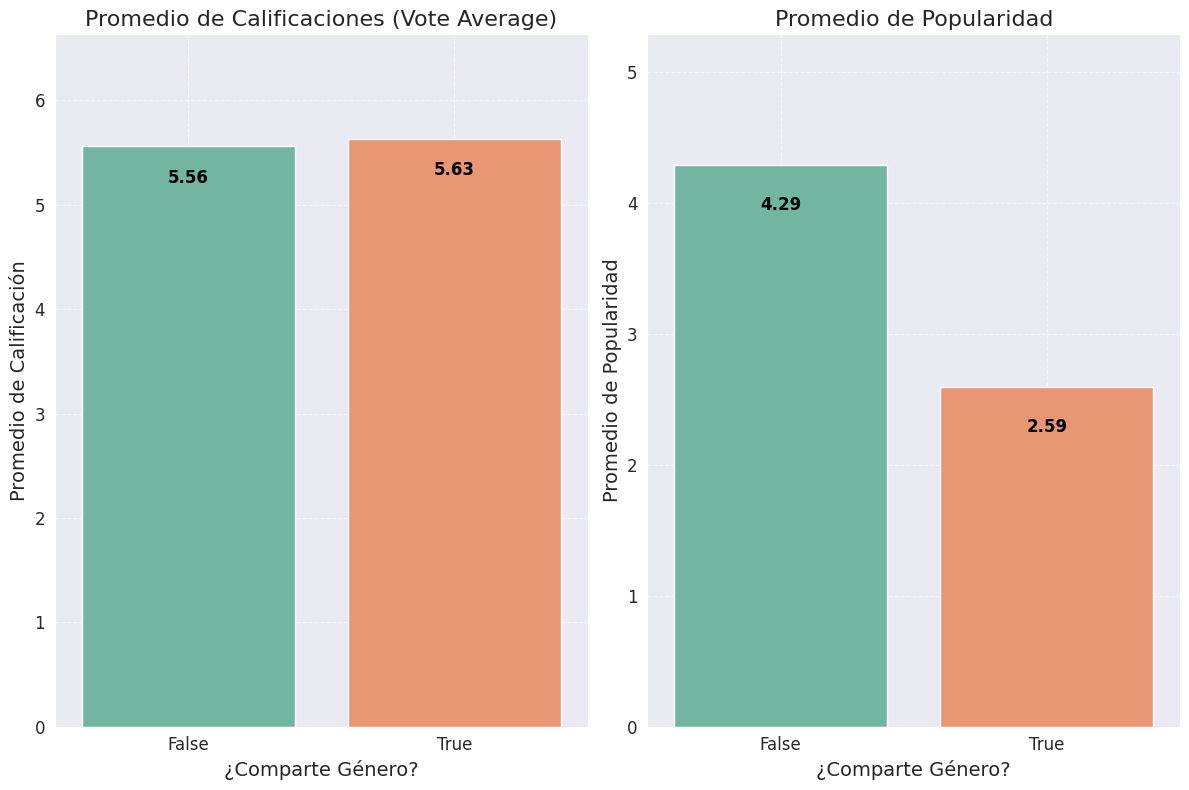

In [92]:
# Crear un gráfico de barras para comparar las medias de vote_average y popularity
fig, ax = plt.subplots(1, 2, figsize=(12, 8))

# Paleta de colores
palette = sns.color_palette("Set2")

# Función para agregar etiquetas de valor dentro de cada barra
def add_value_labels(ax, spacing=5):
    """Agregar etiquetas de valor dentro de las barras."""
    for p in ax.patches:
        _x = p.get_x() + p.get_width() / 2
        _y = p.get_height()
        value = f'{_y:.2f}'  # Mostrar valores con 2 decimales
        ax.text(_x, _y - spacing, value, ha="center", va="center", color="black", fontsize=12, weight='bold')

# Gráfico de barras para vote_average
sns.barplot(x=shared_genre_stats.index, y=shared_genre_stats['vote_average'], ax=ax[0], palette=palette)
ax[0].set_title('Promedio de Calificaciones (Vote Average)', fontsize=16)
ax[0].set_xlabel('¿Comparte Género?', fontsize=14)
ax[0].set_ylabel('Promedio de Calificación', fontsize=14)
ax[0].set_ylim(0, shared_genre_stats['vote_average'].max() + 1)  # Ajustar el límite superior
add_value_labels(ax[0], spacing=0.3)  # Agregar etiquetas dentro de la barra

# Gráfico de barras para popularity
sns.barplot(x=shared_genre_stats.index, y=shared_genre_stats['popularity'], ax=ax[1], palette=palette)
ax[1].set_title('Promedio de Popularidad', fontsize=16)
ax[1].set_xlabel('¿Comparte Género?', fontsize=14)
ax[1].set_ylabel('Promedio de Popularidad', fontsize=14)
ax[1].set_ylim(0, shared_genre_stats['popularity'].max() + 1)  # Ajustar el límite superior
add_value_labels(ax[1], spacing=0.3)  # Agregar etiquetas dentro de la barra

# Ajustar tamaños de texto y estéticas del gráfico
for axis in ax:
    for tick in axis.get_xticklabels():
        tick.set_fontsize(12)
    for tick in axis.get_yticklabels():
        tick.set_fontsize(12)

# Añadir rejilla para mayor legibilidad
ax[0].grid(True, linestyle='--', alpha=0.6)
ax[1].grid(True, linestyle='--', alpha=0.6)

plt.tight_layout()
plt.show()

Vemos que las películas que comparten género reciben una clasificación un poco superior a aquellas que no comparten en promedio, sin embargo, llama la atención que las películas que no comparten géneros, son más populares que las que comparten. Puede ocurrir que películas de géneros diversos atraigan a más población debido a un efecto de novedad.

In [93]:
# Comparar cuántas películas 'disfrutadas' comparten el idioma original con las demás
df['is_original_language'] = df['original_language'].isin(disfrutadas['original_language'])

# Agrupar por si el idioma original es compartido y analizar la media de calificaciones y popularidad
shared_original_language_stats = df.groupby('is_original_language')[['vote_average', 'popularity']].mean()

print(shared_original_language_stats)

                      vote_average  popularity
is_original_language                          
False                     4.896875    0.842646
True                      5.619224    2.924409


<ipython-input-94-b9288aa5efb6>:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=shared_original_language_stats.index, y=shared_original_language_stats['vote_average'], ax=ax[0], palette=palette)
<ipython-input-94-b9288aa5efb6>:17: UserWarning: The palette list has more values (8) than needed (2), which may not be intended.
  sns.barplot(x=shared_original_language_stats.index, y=shared_original_language_stats['vote_average'], ax=ax[0], palette=palette)
<ipython-input-94-b9288aa5efb6>:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=shared_original_language_stats.index, y=shared_original_language_stats['popularity'], ax=ax[1], palette=palette)
<ipython-input-94-b9288aa5efb6>:25: UserW

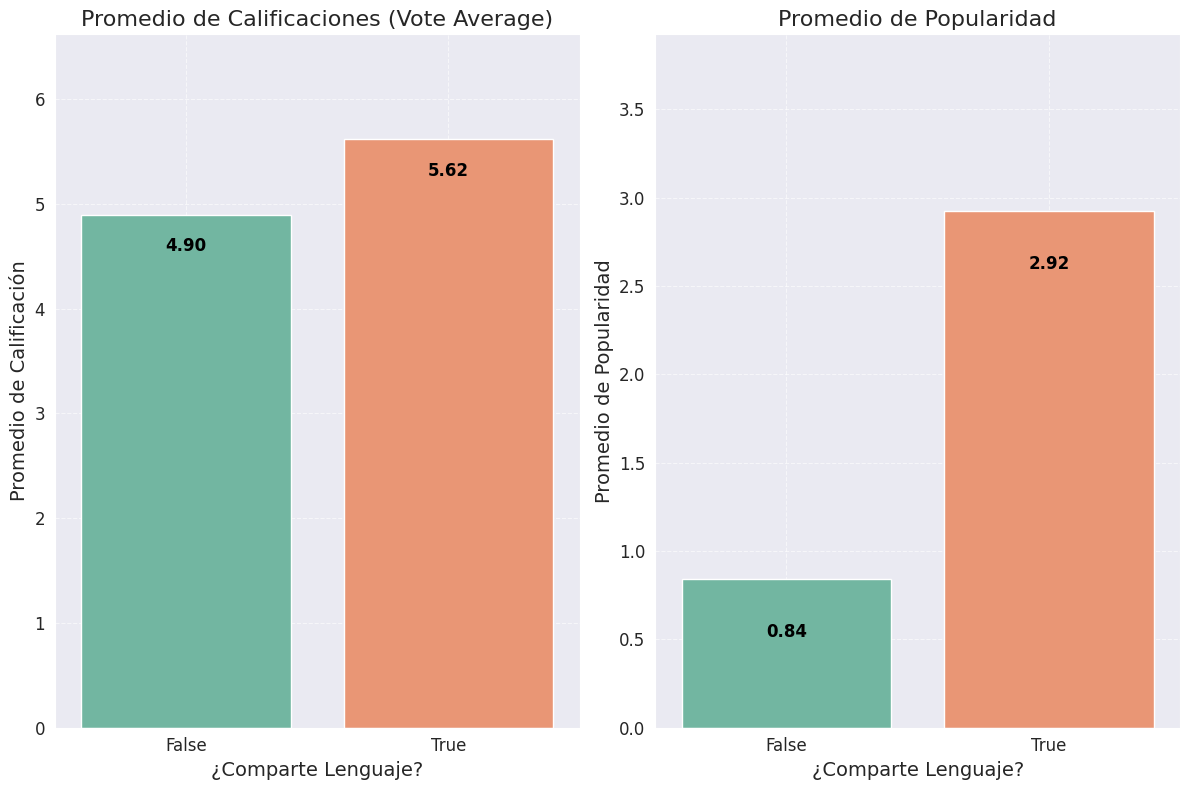

In [94]:
# Crear un gráfico de barras para comparar las medias de vote_average y popularity
fig, ax = plt.subplots(1, 2, figsize=(12, 8))

# Paleta de colores
palette = sns.color_palette("Set2")

# Función para agregar etiquetas de valor dentro de cada barra
def add_value_labels(ax, spacing=5):
    """Agregar etiquetas de valor dentro de las barras."""
    for p in ax.patches:
        _x = p.get_x() + p.get_width() / 2
        _y = p.get_height()
        value = f'{_y:.2f}'  # Mostrar valores con 2 decimales
        ax.text(_x, _y - spacing, value, ha="center", va="center", color="black", fontsize=12, weight='bold')

# Gráfico de barras para vote_average
sns.barplot(x=shared_original_language_stats.index, y=shared_original_language_stats['vote_average'], ax=ax[0], palette=palette)
ax[0].set_title('Promedio de Calificaciones (Vote Average)', fontsize=16)
ax[0].set_xlabel('¿Comparte Lenguaje?', fontsize=14)
ax[0].set_ylabel('Promedio de Calificación', fontsize=14)
ax[0].set_ylim(0, shared_original_language_stats['vote_average'].max() + 1)  # Ajustar el límite superior
add_value_labels(ax[0], spacing=0.3)  # Agregar etiquetas dentro de la barra

# Gráfico de barras para popularity
sns.barplot(x=shared_original_language_stats.index, y=shared_original_language_stats['popularity'], ax=ax[1], palette=palette)
ax[1].set_title('Promedio de Popularidad', fontsize=16)
ax[1].set_xlabel('¿Comparte Lenguaje?', fontsize=14)
ax[1].set_ylabel('Promedio de Popularidad', fontsize=14)
ax[1].set_ylim(0, shared_original_language_stats['popularity'].max() + 1)  # Ajustar el límite superior
add_value_labels(ax[1], spacing=0.3)  # Agregar etiquetas dentro de la barra

# Ajustar tamaños de texto y estéticas del gráfico
for axis in ax:
    for tick in axis.get_xticklabels():
        tick.set_fontsize(12)
    for tick in axis.get_yticklabels():
        tick.set_fontsize(12)

# Añadir rejilla para mayor legibilidad
ax[0].grid(True, linestyle='--', alpha=0.6)
ax[1].grid(True, linestyle='--', alpha=0.6)

plt.tight_layout()
plt.show()

En este caso, vemos que en promedio el vote_average si es un tanto mayor que el caso anterior para las películas que comparten un lenguaje original, lo que podría indicar que las personas evalúan mejor a películas con un idioma que ya disfrutaron. En el caso de la popularidad si vemos un promedio más notable el cambio en aquellas que comparten un idioma de una película disfrutada.

Esto podría señalar como un factor clave en un sistema de recomendación el lenguaje original.

Para la tercera pregunta en particular debemos evaluar el modelo construido por lo que será parte de la entrega final.

# 5. Data Wrangling

En esta sección manejaremos el conjunto de datos para realizar el trabajo sobre datos nulls y outliers, para preparar de una mejor manera para el modelo.

Para el caso de los valores nulos se hará lo siguiente, las columnas que en gran mayoría contiene valores nulls se evaluarán individualmente.

- bellongs_to_collection: Es probable que no todas las películas pertenezcan a una colección, por lo tanto esto se solucionará mediante un fill.na
- hompage: se seguirá el mismo criterio anterior, ya que no todas las películas tienen una página web
- tagline: en este caso es un texto descriptivo por lo que si no existe, se rellenará con un valor vacío
- overview: para el caso de overview, se trabajará de 1 forma distinta debido a que para la variable existen 4 valores, overview, no overview, no overview found y NaN, tanto nullos como "no overview found" pasarán a ser no overview.
- poster_path: al ser strings que indican archivos .jpg se mantendrán como vacío
- runtime: para esta variable debido a que se observa una curva normal con una cantidad de valores outliers y que la cantidad de registros nulls de el total es un nivel bajo (menor a 1%) se utilizará la mediana para remplazar este valor.
- status: dado que no podríamos de alguna manera determinar un estado, ni considerar un status vacío se eliminarán estos registros
- release_date: dado que no podríamos de alguna manera determinar un estado, ni considerar un status vacío se eliminarán estos registros
- El resto de las variables dado que la cantidad de nulls es bastante menor serán eliminado de los registros todas aquellas filas con problemas, entiendo que son menos del 0.1%

Esto implicaría eliminar el 0.5% de la base en total considerando la suma de todos los registros eliminados, lo que no se considera un riesgo dada la cantidad de datos disponibles.

In [95]:
# 1. Rellenar valores nulos en 'belongs_to_collection' con 'No Collection'
df['belongs_to_collection'].fillna('No Collection', inplace=True)

# 2. Rellenar valores nulos en 'homepage' con 'No Homepage'
df['homepage'].fillna('No Homepage', inplace=True)

# 3. Rellenar valores nulos en 'tagline' con valor vacío
df['tagline'].fillna('', inplace=True)

# 4. Para 'overview', convertir NaN y 'no overview found' a 'No Overview'
df['overview'] = df['overview'].replace(['no overview found', np.nan], 'No Overview')

# 5. Rellenar valores nulos en 'poster_path' con valor vacío
df['poster_path'].fillna('', inplace=True)

# 6. Rellenar valores nulos en 'runtime' con la mediana
if df['runtime'].notnull().any():  # Verificamos si la columna tiene valores válidos
    df['runtime'].fillna(df['runtime'].median(), inplace=True)

# 7. Eliminar registros donde 'status' tenga valores nulos
df.dropna(subset=['status'], inplace=True)

# 8. Eliminar registros donde 'release_date' tenga valores nulos
df.dropna(subset=['release_date'], inplace=True)

# 9. Eliminar todas las filas con valores nulos en las demás columnas
# Solo se eliminan las filas con nulls en otras variables donde el porcentaje es bajo (<0.1%)
threshold = 0.001  # Menos del 0.1%
cols_with_few_nulls = df.columns[df.isnull().mean() < threshold]
df = df.dropna(subset=cols_with_few_nulls)

<ipython-input-95-06fe9f2fa211>:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['belongs_to_collection'].fillna('No Collection', inplace=True)
<ipython-input-95-06fe9f2fa211>:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace

In [96]:
# Verificar el número de registros eliminados y restantes
print(f"Número de registros restantes: {len(df)}")

# Verificaremos la cantidad de valores nulos en el dataset
missing_values_2 = df.isnull().sum()

# Calculamos la cantidad de columnas que tienen valores nulos
num_columns_with_nulls_2 = missing_values_2[missing_values_2 > 0].count()
# Calculamos la cantidad total de columnas en el DataFrame
total_columns_2 = df.shape[1]
# Calculamos el porcentaje de columnas con valores nulls
perc_missing_values_2 = num_columns_with_nulls_2 / total_columns_2 * 100

# Mostramos los resultados
print(f"Cantidad de variables con valores nulos: {num_columns_with_nulls_2}")
print(f"Cantidad total de variables: {perc_missing_values_2}%")
print(f"")
print("Cantidad de valores nulos por variable")
# Ordenamos los valores missing para comprender las variables más afectadas
missing_values_sorted_2 = missing_values_2[missing_values_2 > 0].sort_values(ascending=False)
print(missing_values_sorted_2)

Número de registros restantes: 45271
Cantidad de variables con valores nulos: 0
Cantidad total de variables: 0.0%

Cantidad de valores nulos por variable
Series([], dtype: int64)


Vemos que efectivamente, no tenemos variables con nulls y que la cantidad de registros se redujo en 195 registros, en torno al 0.4% del dataset original.

Para el caso de los valores outliers se transformarán las variables numéricas, para reducir sus valores, debido a la importancia de las variables en este experimento. Comenzaremos identificando las variables numércicas del dataset

In [97]:
numerical_columns = df.select_dtypes(include=["int64", "float64"]).columns
numerical_columns

Index(['budget', 'popularity', 'revenue', 'runtime', 'vote_average',
       'vote_count'],
      dtype='object')

Se realizará lo siguiente para los outliers de cada variables. Debemos considerar que con anterioridad se revisaron estos outliers en boxplot

- budget: debido a que existen películas con alto y bajo presupuesto se aplicará una transformación logarítimica para reducir la asimetría
- popularity: al igual que la variable anterior pueden existir películas con mayor o menor popularidad, por lo que es recomendable una transformación logarítmica.
- revenue: se utiliza el mismo caso anterior, es decir aplicar una transformación logarítmica.
- runtime: en este caso, se pueden realizar un análisis más en profundidad y pensar que las películas en promedio pueden durar entre 60 min y 200 min, podríamos acotar a esto, pensando en que queremos analizar películas y no cortometrajes o largometrajes, sin emabrgo, como no tenemos evidencia que respalde esto se mantendrán los valores outliers.
- vote_average: debido al significado del promedio de votación y que es basado en una perspectiva de la audiencia se mantienen los valores atípicos, pues son considerados válidos.
- vote_count: se aplicará una transformación logarítmica para poder reducir el sesgo

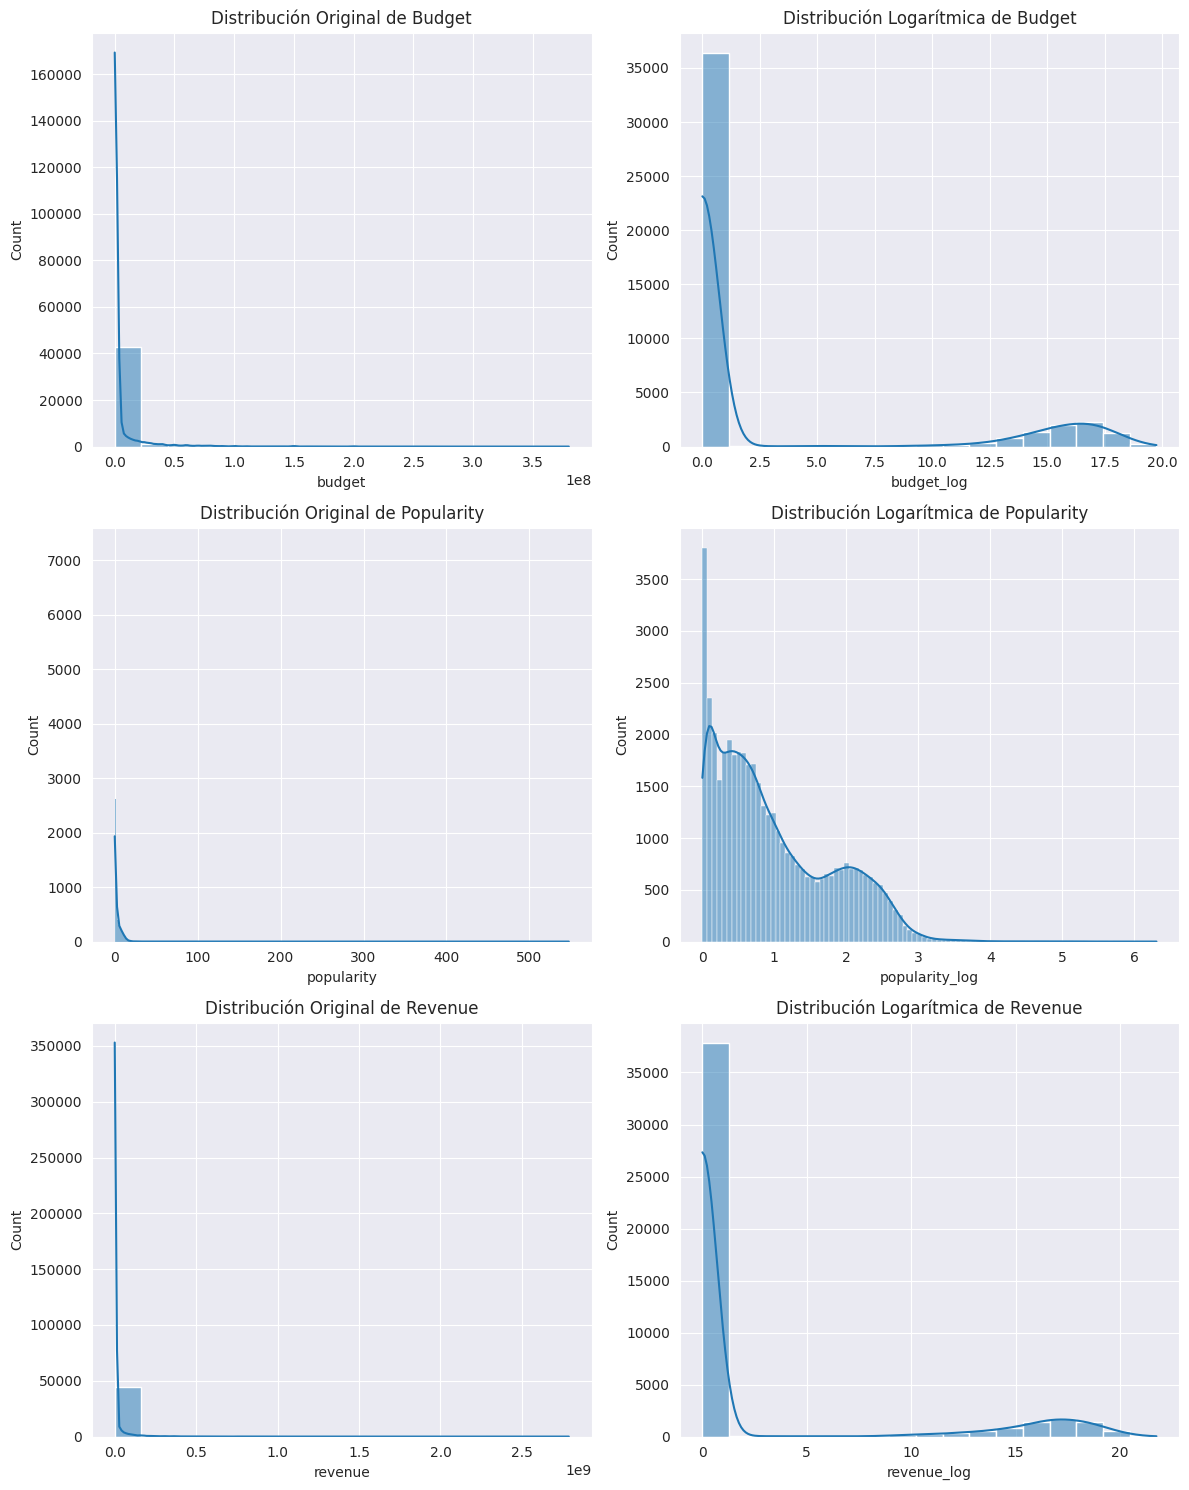

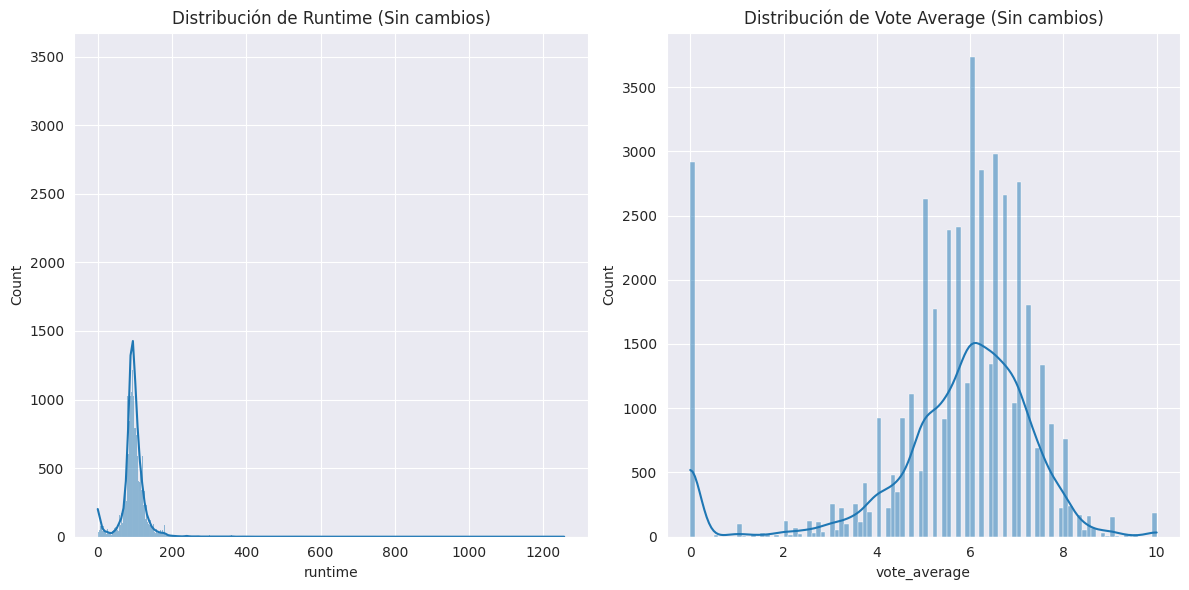

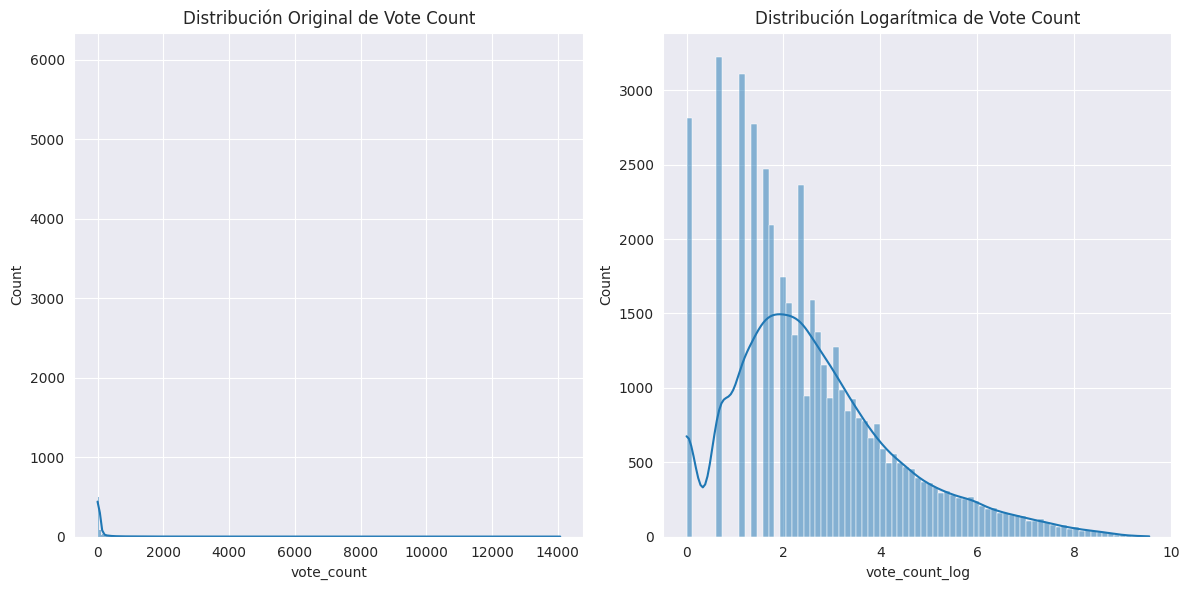

In [98]:
# 1. Transformación logarítmica para 'budget', 'popularity', 'revenue', y 'vote_count'
df['budget_log'] = np.log1p(df['budget'])  # log1p aplica log(x + 1) para evitar log(0)
df['popularity_log'] = np.log1p(df['popularity'])
df['revenue_log'] = np.log1p(df['revenue'])
df['vote_count_log'] = np.log1p(df['vote_count'])

# 2. Para 'runtime' y 'vote_average', los outliers se mantendrán
# Por lo tanto, no realizamos ninguna transformación o eliminación de outliers

# Visualización para comprobar las transformaciones
fig, axes = plt.subplots(3, 2, figsize=(12, 15))

# Distribución original y logarítmica de 'budget'
sns.histplot(df['budget'], kde=True, ax=axes[0, 0])
axes[0, 0].set_title('Distribución Original de Budget')

sns.histplot(df['budget_log'], kde=True, ax=axes[0, 1])
axes[0, 1].set_title('Distribución Logarítmica de Budget')

# Distribución original y logarítmica de 'popularity'
sns.histplot(df['popularity'], kde=True, ax=axes[1, 0])
axes[1, 0].set_title('Distribución Original de Popularity')

sns.histplot(df['popularity_log'], kde=True, ax=axes[1, 1])
axes[1, 1].set_title('Distribución Logarítmica de Popularity')

# Distribución original y logarítmica de 'revenue'
sns.histplot(df['revenue'], kde=True, ax=axes[2, 0])
axes[2, 0].set_title('Distribución Original de Revenue')

sns.histplot(df['revenue_log'], kde=True, ax=axes[2, 1])
axes[2, 1].set_title('Distribución Logarítmica de Revenue')

plt.tight_layout()
plt.show()

# Visualización de 'runtime' y 'vote_average', donde no se transformarán los outliers
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Distribución de 'runtime'
sns.histplot(df['runtime'], kde=True, ax=axes[0])
axes[0].set_title('Distribución de Runtime (Sin cambios)')

# Distribución de 'vote_average'
sns.histplot(df['vote_average'], kde=True, ax=axes[1])
axes[1].set_title('Distribución de Vote Average (Sin cambios)')

plt.tight_layout()
plt.show()

# Distribución original y logarítmica de 'vote_count'
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

sns.histplot(df['vote_count'], kde=True, ax=axes[0])
axes[0].set_title('Distribución Original de Vote Count')

sns.histplot(df['vote_count_log'], kde=True, ax=axes[1])
axes[1].set_title('Distribución Logarítmica de Vote Count')

plt.tight_layout()
plt.show()

Vemos que las distribuciones parecen un poco más normales, por lo que las transformaciones logarítimicas fueron útiles. Se podría seguir trabajando generando cortes para estos outliers quitando cotas superiores e inferiores (1% y 99% o 5% y 95%) en este caso no aplicaremos esto a menos que sea necesario para mejorar el modelo.

Adicionalmente crearemos una lista de variables sintéticas que sumarán al modelo

In [99]:
# Crear variables sintéticas adicionales
df['budget_to_revenue'] = df['budget_log'] / (df['revenue_log'] + 1e-10)  # Para evitar división por 0
df['duration_normalized'] = (df['runtime'] - df['runtime'].mean()) / df['runtime'].std()
df['popularity_normalized'] = (df['popularity_log'] - df['popularity_log'].mean()) / df['popularity_log'].std()
df['weighted_vote_average'] = df['vote_average'] * (df['vote_count_log'] + 1e-10)

# 6. Modelado del problema

Complementaremos la ingeniería de atributos del paso anterior en donde normalizamos y creamos variables útiles para el set con otras variables útiles como lo son el lenguaje original y el género, para los cuáles realizaremos un OneHotEncoder.

In [100]:
# 1. Proceso para la columna 'genres'
# Convertir géneros a una lista
df['genres'] = df['genres'].fillna('')  # Llenar nulos
df['genres_list'] = df['genres'].apply(lambda x: x.split('|') if isinstance(x, str) else [])

# One-Hot Encoding para los géneros
encoder = OneHotEncoder(sparse_output=False)
genres_encoded = encoder.fit_transform(
    df['genres_list'].apply(lambda x: ' '.join(x)).values.reshape(-1, 1)
)
genres_encoded_df = pd.DataFrame(genres_encoded, columns=encoder.get_feature_names_out(['genres']))

# 2. Proceso para la columna 'original_language'
# One-Hot Encoding para idioma original
df['original_language'] = df['original_language'].fillna('unknown')  # Rellenar nulos
language_encoded = pd.get_dummies(df['original_language'], prefix='lang')

# 3. Crear nuevas características (basado en columnas normalizadas)
# Número de géneros
df['num_genres'] = df['genres_list'].apply(len)

# Ratio de ingresos/presupuesto utilizando columnas logarítmicas
df['revenue_to_budget_ratio_log'] = (df['revenue_log'] / df['budget_log']).replace([np.inf, -np.inf], 0).fillna(0)

# Popularidad escalada por género (normalizada)
df['popularity_scaled_log'] = df['popularity_log'] / (df['num_genres'] + 1)  # Evitar divisiones por 0

# 4. Concatenar todas las características procesadas
# Combinar variables numéricas normalizadas, categóricas codificadas, y nuevas características
features = ['budget_log', 'revenue_log', 'popularity_scaled_log', 'revenue_to_budget_ratio_log', 'vote_count_log', 'num_genres']
final_data = pd.concat([df[features], genres_encoded_df, language_encoded], axis=1)

# Verificar el shape del dataset final
print(f"Shape del dataset procesado: {final_data.shape}")
print(final_data)

Shape del dataset procesado: (45462, 4157)
       budget_log  revenue_log  popularity_scaled_log  \
0       17.216708    19.738573               1.566592   
1       17.989898    19.386893               1.445617   
2        0.000000     0.000000               1.271309   
3       16.588099    18.215526               0.790467   
4        0.000000    18.153832               1.119691   
...           ...          ...                    ...   
45070         NaN          NaN                    NaN   
45090         NaN          NaN                    NaN   
45148         NaN          NaN                    NaN   
45159         NaN          NaN                    NaN   
45203         NaN          NaN                    NaN   

       revenue_to_budget_ratio_log  vote_count_log  num_genres  genres_[]  \
0                         1.146478        8.597113         1.0        0.0   
1                         1.077654        7.789040         1.0        0.0   
2                         0.000000       

Este encoder nos amplificó el dataset a un volumen bastante alto de datos ya que se generaron 4.157 columnas donde tenemos un total cercano a los 190 millones de datos. Por lo que se decide reducir el datset a un 30% para que el procesador pueda manejar de mejor manera los resultados.

In [101]:
# Muestra aleatoria del 30% de los datos
sample_df = final_data.sample(frac=0.3, random_state=42)
print(f"Tamaño de sample_df: {len(sample_df)}")


Tamaño de sample_df: 13639


Hemos logrado reducir la cantidad de datos a un aproximado de 57 millones un número un tanto menor al anterior, aunque de todas maneras es bastante elevado, sin embargo, este número sólo genera un procesamiento lento pero no imposible dada las restricciones computacionales.

Dicho esto comenzaremos a preparar el dataset. Originalmente el objetivo del proyecto era realizar un sistema recomendador, sin embargo, este no permitía realizar la consigna asignada, pero para realizar un proyecto más acorde a este mismo se definió construir un cluster con Kmeans y posteriorment un predictor de este mismo mediante modelos supervisados.

Valores faltantes después de la imputación: 0


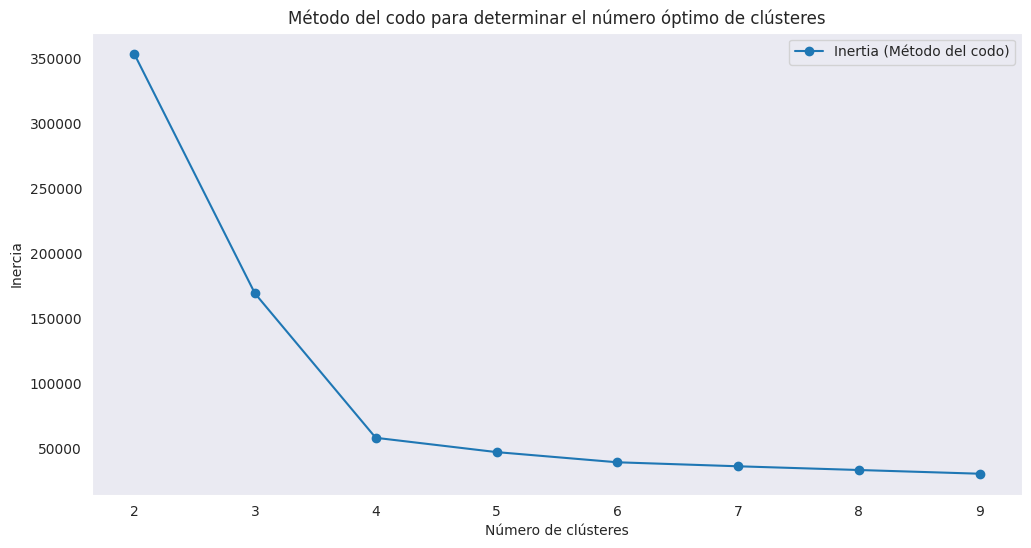

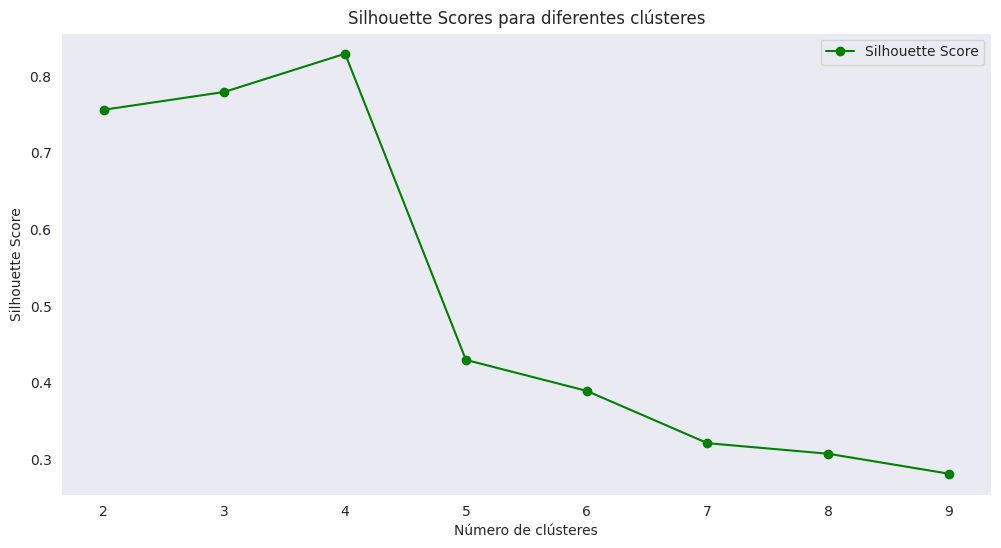

In [102]:
# Imputación de valores faltantes
imputer = SimpleImputer(strategy='mean')  # Rellenar NaN con la media
X = sample_df.values  # Obtener las características en formato de matriz NumPy
X_imputed = imputer.fit_transform(X)

# Eliminar características con baja varianza
selector = VarianceThreshold(threshold=0.01)  # Ajusta el umbral según sea necesario
X_reduced = selector.fit_transform(X_imputed)  # Aplica el selector

# Confirmar que no quedan valores NaN
print(f"Valores faltantes después de la imputación: {np.isnan(X_reduced).sum()}")

# 2. Encontrar el número óptimo de clústeres (Método del codo y Silhouette Score)
inertia = []
silhouette_scores = []
cluster_range = range(2, 10)  # Probar con 2 a 9 clústeres

for k in cluster_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_reduced)
    inertia.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(X_reduced, kmeans.labels_))

# 3. Visualizar el método del codo (Inercia)
plt.figure(figsize=(12, 6))
plt.plot(cluster_range, inertia, marker='o', label='Inertia (Método del codo)')
plt.xlabel('Número de clústeres')
plt.ylabel('Inercia')
plt.title('Método del codo para determinar el número óptimo de clústeres')
plt.grid()
plt.legend()
plt.show()

# 4. Visualizar los puntajes de silhouette
plt.figure(figsize=(12, 6))
plt.plot(cluster_range, silhouette_scores, marker='o', color='green', label='Silhouette Score')
plt.xlabel('Número de clústeres')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Scores para diferentes clústeres')
plt.grid()
plt.legend()
plt.show()



Con silhouette y el método del codo, hemos logrado identificar que el número óptimo de clusters es 4. Por lo que a continuación se generará un modelo de kmeans para 4 clusters.

In [103]:
# 5. Elegir el número óptimo de clústeres (usualmente lo determines visualmente)
optimal_clusters = 4  # Cambia esto según lo observado

# 6. Entrenar el modelo KMeans con el número óptimo de clústeres
kmeans_final = KMeans(n_clusters=optimal_clusters, random_state=42, n_init=10)
kmeans_final.fit(X_reduced)

# 7. Agregar etiquetas de clúster al DataFrame original
df = sample_df.copy()  # Asegúrate de tener el DataFrame original para agregar las etiquetas
df['cluster'] = kmeans_final.labels_

# 8. Analizar los clústeres
cluster_summary = df.groupby('cluster').mean()
print("Resumen de los clústeres:")
print(cluster_summary)

Resumen de los clústeres:
         budget_log  revenue_log  popularity_scaled_log  \
cluster                                                   
0          0.024391     0.016653               0.374074   
1         16.399496    16.967739               1.077483   
2         14.603376     0.061916               0.654508   
3          0.026530    14.397253               0.794803   

         revenue_to_budget_ratio_log  vote_count_log  num_genres  genres_[]  \
cluster                                                                       
0                           0.001537        2.124682         1.0   0.053828   
1                           1.036889        5.536582         1.0   0.033333   
2                           0.004701        3.199636         1.0   0.051205   
3                           0.036475        3.809504         1.0   0.029703   

         genres_[{'id': 10402, 'name': 'Music'}, {'id': 10749, 'name': 'Romance'}, {'id': 10751, 'name': 'Family'}, {'id': 14, 'name': 'Fantasy'

Una vez generados los cluster, hemos decidido generar un modelo supervisado capaz de predecir estos resultados. Es por esto que comenzaremos a preparar las variables para crear un random forest como una regresión logística.

In [104]:
X = df.drop(columns='cluster')  # Características
y = df['cluster']  # Etiquetas generadas por KMeans

# Normalizar las características para mejorar el rendimiento del modelo
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Dividir los datos en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=42)

In [105]:
# Crear el modelo de Random Forest
rf_model = RandomForestClassifier(random_state=42)

# Aplicar validación cruzada
cv_scores_rf = cross_val_score(rf_model, X_train, y_train, cv=5, scoring='accuracy')

# Promediar los resultados de validación cruzada
print(f"Random Forest - Validación Cruzada (Accuracy): {np.mean(cv_scores_rf)}")


Random Forest - Validación Cruzada (Accuracy): 0.8883438328776065


Vemos que en primer lugar, logramos un resultado bastante bueno para el modelo con un Accuracy cercano al 90% es decir este modelo predice el 90% del tiempo de manera correcta.

In [106]:
# Imputar los valores NaN con la media de cada columna
imputer = SimpleImputer(strategy='mean')
X_train_imputed = imputer.fit_transform(X_train)

# Normalizar las características
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_train_imputed)

# Crear el modelo de Logistic Regression con manejo de desbalanceo
log_reg_model = LogisticRegression(max_iter=1000, random_state=42, class_weight='balanced')

# Aplicar validación cruzada
cv_scores_lr = cross_val_score(log_reg_model, X_scaled, y_train, cv=5, scoring='accuracy', error_score='raise')

# Promediar los resultados de validación cruzada
print(f"Logistic Regression - Validación Cruzada (Accuracy): {np.mean(cv_scores_lr)}")


Logistic Regression - Validación Cruzada (Accuracy): 0.9985337571547286


Vemos que para el caso de regresión logística, se logró un resultado aún mejor que incluso es cercano a 1, lo que lo convierte en algo sospechoso, ya que podría ser que este modelo tenga alguna especie de overfitting.

In [107]:
# Entrenar el modelo con el conjunto de entrenamiento
rf_model.fit(X_train, y_train)

# Predecir en el conjunto de prueba
y_pred_rf = rf_model.predict(X_test)

# Evaluar el modelo
print("Evaluación de Random Forest en conjunto de prueba:")
print(f"Exactitud: {accuracy_score(y_test, y_pred_rf)}")
print("Reporte de clasificación:")
print(classification_report(y_test, y_pred_rf))


Evaluación de Random Forest en conjunto de prueba:
Exactitud: 0.8709677419354839
Reporte de clasificación:
              precision    recall  f1-score   support

           0       0.86      1.00      0.92      3144
           1       1.00      0.81      0.89       463
           2       1.00      0.01      0.01       303
           3       1.00      0.24      0.38       182

    accuracy                           0.87      4092
   macro avg       0.96      0.51      0.55      4092
weighted avg       0.89      0.87      0.83      4092



Si comparamos con otras medidas vemos que el random forest tiene un buen rendimiento en general pero tuvo un valor de f-1 score bastante bajo para el rendimiento en el clsuter 02 debido al bajo recall obtenido, de la misma manera ocurre para el cluster 3. Teniendo un promedio de 0.55 en este indicado y un promedio ponderado de 0.83

In [108]:
# Imputar los valores NaN en X_train y X_test con la media de cada columna
imputer = SimpleImputer(strategy='mean')

# Imputar X_train
X_train_imputed = imputer.fit_transform(X_train)

# Imputar X_test utilizando el mismo imputador para mantener la coherencia
X_test_imputed = imputer.transform(X_test)

# Crear y entrenar el modelo
log_reg_model = LogisticRegression(max_iter=1000, random_state=42)
log_reg_model.fit(X_train_imputed, y_train)

# Predecir en el conjunto de prueba
y_pred_lr = log_reg_model.predict(X_test_imputed)

# Evaluar el modelo
print("Evaluación de Logistic Regression en conjunto de prueba:")
print(f"Exactitud: {accuracy_score(y_test, y_pred_lr)}")
print("Reporte de clasificación:")
print(classification_report(y_test, y_pred_lr))


Evaluación de Logistic Regression en conjunto de prueba:
Exactitud: 0.9975562072336266
Reporte de clasificación:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3144
           1       0.99      1.00      0.99       463
           2       1.00      0.99      0.99       303
           3       0.99      0.98      0.99       182

    accuracy                           1.00      4092
   macro avg       1.00      0.99      0.99      4092
weighted avg       1.00      1.00      1.00      4092



Por otro lado, los resultados del modelo de regresión logística se ven bastante altos acordes también al accuracy obtenido.

Ahora utilizaremos métodos de Grid para buscar la mejor combinación de hiperparámetros en cada uno de los modelos.

In [109]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

# Definir los rangos de búsqueda
param_dist_rf = {
    'n_estimators': randint(100, 300),  # Rango en lugar de lista fija
    'max_depth': [10, 20, None],
    'min_samples_split': randint(2, 10)  # Rango continuo
}

# Configurar RandomizedSearch
random_search_rf = RandomizedSearchCV(estimator=rf_model, param_distributions=param_dist_rf,
                                      n_iter=10, cv=5, scoring='accuracy', verbose=1, random_state=42)

# Ejecutar la búsqueda
random_search_rf.fit(X_train, y_train)

# Mejor modelo
print(f"Mejores hiperparámetros Random Forest: {random_search_rf.best_params_}")


Fitting 5 folds for each of 10 candidates, totalling 50 fits
Mejores hiperparámetros Random Forest: {'max_depth': None, 'min_samples_split': 4, 'n_estimators': 171}


In [110]:
param_grid_lr = {
    'C': [0.01, 0.1, 1, 10],  # Parámetro de regularización
    'solver': ['lbfgs', 'liblinear'],  # Algoritmo de optimización
}

grid_search_lr = GridSearchCV(estimator=log_reg_model, param_grid=param_grid_lr,
                              cv=5, scoring='accuracy', verbose=1)

grid_search_lr.fit(X_train_imputed, y_train)

print(f"Mejores hiperparámetros Logistic Regression: {grid_search_lr.best_params_}")


Fitting 5 folds for each of 8 candidates, totalling 40 fits
Mejores hiperparámetros Logistic Regression: {'C': 1, 'solver': 'lbfgs'}


In [119]:
# Random Forest: Predecir probabilidades
y_pred_proba_rf = random_search_rf.best_estimator_.predict_proba(X_test_imputed)
roc_auc_rf = roc_auc_score(y_test, y_pred_proba_rf, multi_class='ovr', average='macro')
accuracy_rf = accuracy_score(y_test, random_search_rf.best_estimator_.predict(X_test_imputed))

print(f"Random Forest - AUC-ROC: {roc_auc_rf:.4f}, Accuracy: {accuracy_rf:.4f}")
print("Reporte de clasificación para Random Forest:")
print(classification_report(y_test, random_search_rf.best_estimator_.predict(X_test_imputed)))

# Logistic Regression: Predecir probabilidades
y_pred_proba_lr = log_reg_model.predict_proba(X_test_imputed)
roc_auc_lr = roc_auc_score(y_test, y_pred_proba_lr, multi_class='ovr', average='macro')
accuracy_lr = accuracy_score(y_test, y_pred_lr)

print(f"Logistic Regression - AUC-ROC: {roc_auc_lr:.4f}, Accuracy: {accuracy_lr:.4f}")
print("Reporte de clasificación para Logistic Regression:")
print(classification_report(y_test, y_pred_lr))


Random Forest - AUC-ROC: 0.9995, Accuracy: 0.8419
Reporte de clasificación para Random Forest:
              precision    recall  f1-score   support

           0       0.83      1.00      0.91      3144
           1       1.00      0.64      0.78       463
           2       0.00      0.00      0.00       303
           3       1.00      0.03      0.05       182

    accuracy                           0.84      4092
   macro avg       0.71      0.42      0.44      4092
weighted avg       0.79      0.84      0.79      4092

Logistic Regression - AUC-ROC: 1.0000, Accuracy: 0.9976
Reporte de clasificación para Logistic Regression:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3144
           1       0.99      1.00      0.99       463
           2       1.00      0.99      0.99       303
           3       0.99      0.98      0.99       182

    accuracy                           1.00      4092
   macro avg       1.00      0.99    

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Ahora con los mejores parámetros vemos que el resultado del random forest mejora un poco el accuracy obtenido, pero sigue con un bajo valor tanto para el cluster 2 como para el 3. Por otro lado el modelo de regresión logística mantiene los altos valores obtenidos.

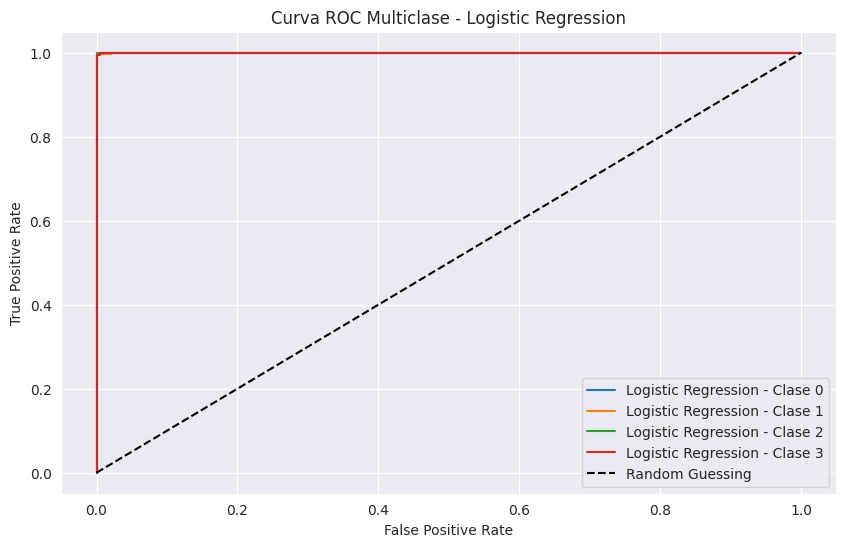

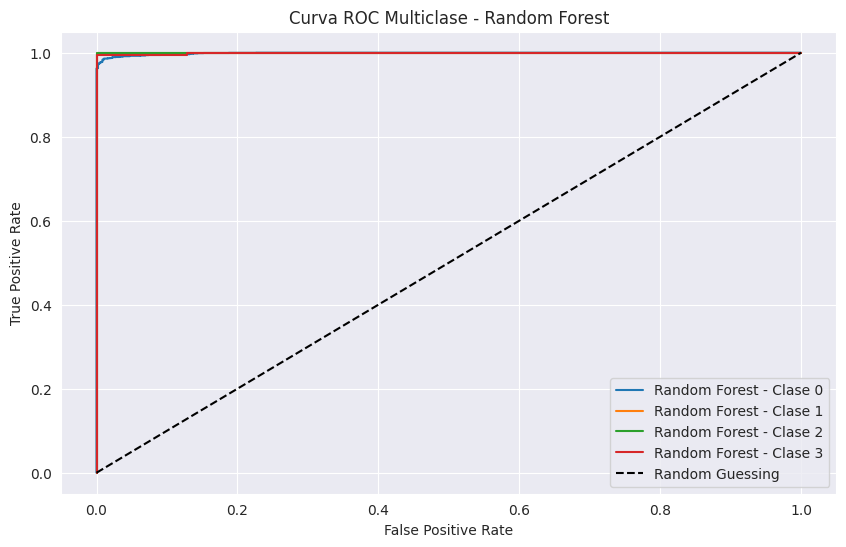

In [127]:
# LOGISTIC REGRESSION: Obtener predicciones probabilísticas y calcular curvas ROC
n_classes_lr = len(log_reg_model.classes_)
fpr_lr = {}
tpr_lr = {}

for i in range(n_classes_lr):
    fpr_lr[i], tpr_lr[i], _ = roc_curve(y_test == i, log_reg_model.predict_proba(X_test_imputed)[:, i])

# Graficar ROC para Logistic Regression
plt.figure(figsize=(10, 6))
for i in range(n_classes_lr):
    plt.plot(fpr_lr[i], tpr_lr[i], label=f'Logistic Regression - Clase {i}')
plt.plot([0, 1], [0, 1], 'k--', label='Random Guessing')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Curva ROC Multiclase - Logistic Regression')
plt.legend()
plt.show()


# RANDOM FOREST: Obtener predicciones probabilísticas y calcular curvas ROC
n_classes_rf = len(random_search_rf.best_estimator_.classes_)
fpr_rf = {}
tpr_rf = {}

for i in range(n_classes_rf):
    fpr_rf[i], tpr_rf[i], _ = roc_curve(y_test == i, random_search_rf.best_estimator_.predict_proba(X_test_imputed)[:, i])

# Graficar ROC para Random Forest
plt.figure(figsize=(10, 6))
for i in range(n_classes_rf):
    plt.plot(fpr_rf[i], tpr_rf[i], label=f'Random Forest - Clase {i}')
plt.plot([0, 1], [0, 1], 'k--', label='Random Guessing')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Curva ROC Multiclase - Random Forest')
plt.legend()
plt.show()

Finalmente se opta por escoger el modelo de random forest, debido a la elevada predicción del modelo de regresión logística, se piensa preeliminarmente que este modelo está sobreentrenado y para continuidad del proyecto se recomendaría realizar prueba de overfitting. También se debe señalar que al escoger este modelo entramos en riesgo de predecir mal el cluster 2 y 3, sin embargo, pareciera ser que predice bien la gran mayoría de los casos al estar estos más cargados hacia el cluster 1.